In [73]:
from OSCC_postprocessing.playback.video_playback import *
from OSCC_postprocessing.analysis.hysteresis import *

# Importing libraries
from OSCC_postprocessing.analysis.multihole_utils import (
    preprocess_multihole,
    resolve_backend,
    rotate_segments_with_masks,
    compute_td_intensity_maps,
    estimate_peak_brightness_frames,
    # estimate_hydraulic_delay,
    compute_penetration_profiles,
    clean_penetration_profiles,
    binarize_plume_videos,
    compute_cone_angle_from_angular_density,
    estimate_offset_from_fft,
    triangle_binarize_gpu as _triangle_binarize_gpu,  # Backward compatibility
)

import time
import warnings

import matplotlib.pyplot as plt
import numpy as np

from OSCC_postprocessing.analysis.cone_angle import angle_signal_density_auto
from OSCC_postprocessing.binary_ops.functions_bw import bw_boundaries_all_points
from OSCC_postprocessing.rotation.rotate_crop import generate_CropRect
from OSCC_postprocessing.analysis.multihole_utils import (
    preprocess_multihole,
    resolve_backend,
    rotate_segments_with_masks,
    compute_td_intensity_maps,
    estimate_peak_brightness_frames,
    # estimate_hydraulic_delay,
    compute_penetration_profiles,
    clean_penetration_profiles,
    binarize_plume_videos,
    compute_cone_angle_from_angular_density,
    estimate_offset_from_fft,
    triangle_binarize_gpu as _triangle_binarize_gpu,  # Backward compatibility
)

from OSCC_postprocessing.analysis.single_plume import (
    pre_processing_mie,
)

from OSCC_postprocessing.rotation.rotate_with_alignment_cpu import (
    rotate_video_nozzle_at_0_half_numpy,
)
warnings.filterwarnings("ignore", category=RuntimeWarning)

global timing
timing = True

if timing:
    import time
import numpy as np
from OSCC_postprocessing.io.async_npz_saver import AsyncNPZSaver
from OSCC_postprocessing.io.async_avi_saver import *
from OSCC_postprocessing.filters.video_filters import *
from OSCC_postprocessing.playback.video_playback import *
from OSCC_postprocessing.analysis.single_plume import (
    USING_CUPY,
    cp,
    _min_max_scale,
    _rotate_align_video_cpu,
    binarize_single_plume_video,
    bw_boundaries_all_points_single_plume,
    bw_boundaries_xband_filter_single_plume,
    filter_schlieren,
    linear_regression_fixed_intercept,
    penetration_bw_to_index,
    pre_processing_mie,
    ransac_fixed_intercept,
    save_boundary_csv,
    to_numpy,
)
from OSCC_postprocessing.analysis.cone_angle import angle_signal_density_auto
from OSCC_postprocessing.binary_ops.binarized_metrics import processing_from_binarized_video
import pandas as pd

# Import rotation utility based on backend availability to avoid hard Cupy dependency
if USING_CUPY:
    from OSCC_postprocessing.rotation.rotate_with_alignment import (
        rotate_video_nozzle_at_0_half_cupy as rotate_video_nozzle_at_0_half_backend,
    )
else:
    from OSCC_postprocessing.rotation.rotate_with_alignment_cpu import (
        rotate_video_nozzle_at_0_half_numpy as rotate_video_nozzle_at_0_half_backend,
    )


from OSCC_postprocessing.analysis.multihole_utils import *
from OSCC_postprocessing.binary_ops.functions_bw import *
from OSCC_postprocessing.filters.video_filters import median_filter_video_auto, sobel_5x5_kernels, filter_video_fft
from OSCC_postprocessing.filters.svd_background_removal import godec_like
from OSCC_postprocessing.analysis.cone_angle import angle_signal_density_auto
from OSCC_postprocessing.filters.bilateral_filter import (
    bilateral_filter_video_cpu,
    bilateral_filter_video_cupy,
    bilateral_filter_video_volumetric_chunked_halo,
)
from OSCC_postprocessing.io.async_avi_saver import AsyncAVISaver
import numpy as np
import scipy.ndimage as ndi
from scipy.ndimage import binary_fill_holes
import os
import pandas as pd
from concurrent.futures import ThreadPoolExecutor, as_completed
from OSCC_postprocessing.binary_ops.functions_bw import _triangle_threshold_from_hist, _boundary_points_one_frame
from OSCC_postprocessing.analysis.multihole_utils import triangle_binarize_gpu as _triangle_binarize_gpu
from OSCC_postprocessing.filters.bilateral_filter import *
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker

# Check the hardware used for image processing

use_gpu, triangle_backend, xp = resolve_backend(use_gpu="auto", triangle_backend="auto")

print("CUDA is used:", use_gpu)

print("xp represents numpy or cupy? :",xp)

# Selecting image rotation solver based on available hardware
if use_gpu:
    from OSCC_postprocessing.rotation.rotate_with_alignment import (
        rotate_video_nozzle_at_0_half_cupy as rotate_video_nozzle_at_0_half_backend,
    )
else:
    rotate_video_nozzle_at_0_half_backend = rotate_video_nozzle_at_0_half_numpy

from OSCC_postprocessing.cine.functions_videos import *
from pathlib import Path
import json
from OSCC_postprocessing.binary_ops.masking import *
from OSCC_postprocessing.filters.convolution_2D_rawKernel import *
from OSCC_postprocessing.analysis.hysteresis import * 
from OSCC_postprocessing.filters.bilateral_filter_rawKernel import *
from OSCC_postprocessing.analysis.penetration_cdf import penetration_cdf_front, monotone_non_decreasing

def _as_numpy(arr):
    if USING_CUPY and hasattr(arr, "__cuda_array_interface__"):
        return cp.asnumpy(arr)
    return np.asarray(arr)

CUDA is used: True
xp represents numpy or cupy? : <module 'cupy' from 'c:\\Users\\Jiang\\Documents\\Mie_Py\\Mie_Postprocessing_Py\\.venv311\\Lib\\site-packages\\cupy\\__init__.py'>


In [94]:
# The only manual inputs in this file

# Nozzle 1
file = Path(r"G:\OSCC\LubeOil\BC20241003_HZ_Nozzle1\cine\T19\1.cine")
json_file = Path(r"G:\OSCC\LubeOil\BC20241003_HZ_Nozzle1\cine\T23\config.json")

# Nozzle 2
# file = Path(r"G:\OSCC\LubeOil\BC20241017_HZ_Nozzle2\cine\single\T8\T8(2).cine")
# json_file = Path(r"G:\OSCC\LubeOil\BC20241017_HZ_Nozzle2\cine\single\T14\config.json")

# Nozzle 3
# file = Path(r"G:\OSCC\LubeOil\BC20241014_HZ_Nozzle3\Cine\T9\T9(2).cine")
# json_file = Path(r"G:\OSCC\LubeOil\BC20241014_HZ_Nozzle3\Cine\T5\config.json")

In [95]:
# Video is in uint12 
video_bits = 12
brightness_levels = 2.0**video_bits
gamma = 1.0

frames_before_SOI = 10

tp_num = int(file.parts[-2].replace("T", ""))

if tp_num == 1 or tp_num == 10 or tp_num == 19:
    frame_limit = 80
else:
    frame_limit = 50 

# Load the .cine file into a 3D numpy array (gray scale, shape: (Frame, Height, Width))
video = load_cine_video(file, frame_limit=frame_limit)
# Normalize the grayscale video to [0, 1] brightness range
video = xp.asarray(video)/ brightness_levels





F, H, W = video.shape

# Json file contains the metadata
with open(json_file, 'r', encoding='utf-8') as f:
    # Load metadata
    data = json.load(f)
    number_of_plumes = int(data['plumes'])
    # offset = float(data['offset']) # Not used in multi hole (Calculated later by FFT)
    centre = (float(data['centre_x']), float(data['centre_y']))
    ir_ = float(data["inner_radius"])   # inner radius (Injector radius)
    or_ = float(data["outer_radius"])   # outer radius (Quatz window radius)



print(f"The injector has {number_of_plumes} plumes.")
print(f"The nozzle is centred at ({centre[0]:.2f}, {centre[1]:.2f}) in image coordinates.")

Video Info - Width: 768, Height: 768, Frames: 80
The injector has 10 plumes.
The nozzle is centred at (392.50, 378.37) in image coordinates.


In [96]:
# Create annular mask between inner and outer radius to focus on spray region
ring_mask = generate_ring_mask(H, W, centre, ir_, or_)

In [97]:
def refined_log_subtraction(video, frames_before_SOI, xp, q_min=5, q_max=99.99):
    eps = 1e-9
    
    # === 1. Log Space Conversion ===
    lg_video = xp.log(video + eps)

    # [优化点 1]: 使用 Median 代替 Mean
    # 理由：背景估计不应受到偶尔出现的亮点（如宇宙射线或非特异性闪烁）的影响。
    # Median 在统计上对异常值更鲁棒。
    lg_bkg = xp.median(lg_video[:frames_before_SOI], axis=0, keepdims=True)

    # === 2. Calculate dF/F in Log Space ===
    # 数学推导：log(V) - log(B) = log(V/B)
    # exp(log(V/B)) - 1 = V/B - 1 = (V - B) / B = dF/F0
    # 使用 expm1 (exp(x) - 1) 在 x 接近 0 时精度更高
    log_ratio = lg_video - lg_bkg
    dff = xp.expm1(log_ratio)

    # === 3. [核心优化] Intensity Gating (强度门控) ===
    # 理由：你提到需要把暗部变0或梯度变平。
    # 仅仅依靠 dff 无法区分 "暗部的噪声波动" 和 "亮部的微弱信号"。
    # 我们必须利用原始亮度信息。
    
    # 计算背景的绝对亮度阈值 (比如背景中位数的 1.2 倍作为噪声底)
    # 注意：这里是在线性空间计算阈值
    raw_bkg = xp.exp(lg_bkg)
    noise_floor_mask = video > (raw_bkg * 1.5) # 1.5 是经验值，可调，表示只有亮度超过背景50%的像素才被视为有效
    
    # 应用门控：将暗部区域平滑过渡到 0
    # 这里使用乘法掩膜，不仅处理了值，也平滑了梯度
    dff *= noise_floor_mask

    # === 4. [核心优化] Baseline Alignment & Soft Thresholding ===
    # 对齐基线
    baseline = xp.median(dff[:frames_before_SOI], axis=0, keepdims=True)
    dff -= baseline

    # [关键]: 使用 Soft Thresholding 代替 Hard Clip
    # Hard Clip (x < 0 -> 0) 会产生折角，高通滤波会把折角识别为高频信号。
    # Softplus 或 ReLU 的平滑变体可以保持导数连续性。
    # 这里我们使用一个简单的平滑过渡：
    # 只有当信号显著大于 0 时才保留，微小的正负波动都视为 0
    
    threshold = 0.05 # 过滤掉 5% 以下的微小 dF/F 波动
    # 软阈值公式: sign(x) * max(|x| - thresh, 0) -> 仅保留正向部分则变为 max(x - thresh, 0)
    # 但为了更平滑，我们可以用 xp.maximum(dff - threshold, 0) 
    # 或者更进一步，使用 Softplus: log(1 + exp(k*x))
    
    dff_clean = xp.maximum(dff - threshold, 0)

    # === 5. Scale ===
    # 使用之前定义的鲁棒缩放
    final_output = robust_scale(dff_clean, q_min=q_min, q_max=q_max) # q_min可以略低，因为我们要保留0

    return final_output

In [98]:
def arr_3d_sobel_magnitude_cupy(arr_3d, wsize=3, sigma=1.0):
    # === Highpass filter ===
    sobel_x = make_kernel("sobel", wsize, sigma, direction="x")
    sobel_y = make_kernel("sobel", wsize, sigma, direction="y")
    sb_filt_x = convolution_2D_cupy(arr_3d, sobel_x)
    sb_filt_y = convolution_2D_cupy(arr_3d, sobel_y)
    return xp.sqrt(sb_filt_x ** 2 + sb_filt_y ** 2)

In [99]:
def mie_multihole_preprocessing(
                                video, 
                                ring_mask,
                                wsize=3,
                                sigma=1.0,
                                chamber_mask=None,
                                binarize_each_frame_after_peak=False
                                ):
        

        lg_foreground = refined_log_subtraction(video, frames_before_SOI, xp)

        # Sobel Magnitude
        sb_mag = arr_3d_sobel_magnitude_cupy(lg_foreground, wsize=wsize, sigma=sigma)

        # Scale linearly to [0, 1]
        # lg_foreground_highpass = _min_max_scale(sb_mag)
        lg_foreground_highpass = robust_scale(sb_mag, q_min=5, q_max=99.9999)
        
        # Frame-wise sum
        energy_highpass = xp.sum(lg_foreground_highpass, axis=(1,2))

        # Find the brightest frame and their intensity for each plume
        brightness_peaks = _as_numpy(xp.argmax(energy_highpass).item())

        # Normalize the intensity of the brightest frame to 1 for each plume
        peak_intensity_sums = xp.max(energy_highpass)
        energy_highpass /= peak_intensity_sums


        # lg_foreground_highpass_compensated = bilateral_filter_video_cupy_fast(lg_foreground_highpass, 3, 3,1)
        lg_foreground_highpass_compensated =  lg_foreground_highpass

        # Binairzing the whole video
        # bw_foreground_unified = xp.zeros_like(video)

        # === Global Threshold ===
        # bw_foreground_unified = triangle_binarize_gpu(lg_foreground_highpass_compensated)


        # === Per Frame Threshold (optional)===

        # if binarize_each_frame_after_peak:
            # Global Threshold up to peak intensity frame
            # bw_foreground_unified[:int(brightness_peaks)] = triangle_binarize_gpu(lg_foreground_highpass[:int(brightness_peaks)]) 

            # for f in range(F):
            #    if f >= int(brightness_peaks):
            #        bw_foreground_unified[f] = triangle_binarize_gpu(lg_foreground_highpass[f]) 
            

        # === Apply ring masks ===
        lg_foreground*= ring_mask[None, :, :]
        
        lg_foreground_highpass_compensated *= ring_mask[None, :, :]

        # bw_foreground_unified*= ring_mask[None, :, :]

        # === Apply chamber masks (optional) ===

        if chamber_mask is not None:
            chamber_mask = xp.asarray(chamber_mask)
            lg_foreground_highpass_compensated *= chamber_mask[None, :, :]

            # bw_foreground_unified*= chamber_mask[None, :, :]

        return lg_foreground, lg_foreground_highpass_compensated# , bw_foreground_unified

In [100]:
def mie_multihole_postprocessing(foreground, highpass, 
                                 centre, number_of_plumes, inner_radius, outer_radius,
                                 bins=720, 
                                 
                                 ):
    
    F, H, W = foreground.shape

    # === Angular Signal Density Analysis ===

    # Compute angular signal distribution around the nozzle centre
    _, total_angular_signal_density, _ = angle_signal_density_auto(
        highpass, centre[0], centre[1], N_bins=bins
    )

    # === Find Optimal Rotation Offset ===
    # Use FFT to find the best offset that aligns with plume periodicity
    offset = estimate_offset_from_fft(total_angular_signal_density, number_of_plumes)

    # Calculate rotation angles for each plume (evenly spaced with offset correction)
    angles = np.linspace(0, 360, number_of_plumes, endpoint=False) - _as_numpy(offset)

    # === Compute Occupied Angles ===
    # Create bin-wise mask and fill small gaps to get continuous plume regions
    bin_wise_mask = fill_short_false_runs(
        _triangle_binarize_gpu(xp.sum(total_angular_signal_density, axis=0), ignore_zeros=True), 
        max_len=3
        )

    # Calculate angular span of each plume region
    occupied_angles = periodic_true_segment_lengths(bin_wise_mask)
    # Average angular width per plume in degrees
    average_occupied_angle = (bin_wise_mask.sum() / bins * 360.0 / number_of_plumes).item()

    # Generate 2D angular mask from the 1D signal density
    angular_mask = generate_angular_mask_from_tf(H, W, centre, total_angular_signal_density, bins)

    ang_int_sum = _min_max_scale(xp.sum(total_angular_signal_density, axis=0))

    # Bin-wise mask 
    TF = triangle_binarize_gpu(median_filter(ang_int_sum, 5))

    average_occupied_angle = TF.sum()/bins*360.0/number_of_plumes

    # =============================================
    # Rotation: Highpass 
 
    # Frames, Height, Width
    F, H, W = video.shape

    # Allocate collector
    segments = []

    # Image rotation settings
    INTERPOLATION = "nearest"
    BORDER_MODE = "constant"

    # Arbitrary rotated image strip shape
    OUT_SHAPE = (int(outer_radius)//2, int(outer_radius))


    for idx, angle in enumerate(angles):
        segment, _, _ = rotate_video_nozzle_at_0_half_backend(
                highpass,
                centre, # (nozzle_x, nozzle_y) # change to centre_x + cos(angle) * r, centre_y + sin(angle) * r
                # (centre[0] + np.cos(angle/180.0*np.pi) * ir_, centre[1] + np.sin(angle/180.0*np.pi) * ir_),
                angle,
                interpolation=INTERPOLATION,
                border_mode=BORDER_MODE,
                out_shape=OUT_SHAPE,
            )
        
        segment = _min_max_scale(segment)
        segments.append(segment)

    segments_fg = xp.stack(segments, axis=0)  # (Plume idx, Frame, H, W)

    P, F, H, W = segments_fg.shape
    
    # plume_mask = generate_plume_mask(W, H, average_occupied_angle.get()*1.5, int(inner_radius))
    
    plume_mask = generate_plume_mask(W, H, 360.0/number_of_plumes, int(inner_radius))
    
    segments_fg *= xp.asarray(plume_mask[None, None, :, :])


    return segments_fg

In [101]:
def robust_scale_arr_4d(arr_4d, q_min=5, q_max=99):
    P, F, H, W = arr_4d.shape

    # Robust scale & Histogram clipping for each plume video (3d array)
    for p, arr_3d in enumerate(arr_4d):
        arr_4d[p] = robust_scale(arr_3d, q_min=q_min, q_max=q_max)
        
    return arr_4d

In [102]:
def penetration_cdf_all_plumes(arr_4d, inner_radius, quantile = 1.0-3e-2):

    # Sum over H axis
    heatmaps = xp.sum(arr_4d, axis=2) # P, F, W


    # 1. Initialize the storage array with the same shape as penetration_td
    # We assume penetration_td is already defined in your context
    penetration_cdf_all = np.zeros((heatmaps.shape[0], heatmaps.shape[1]))

    # 2. Iterate through all available indices
    # We use the length of the map list to determine the range
    for idx in range(len(heatmaps)):
        
        # Retrieve data
        I = heatmaps[idx]

        I -= xp.median(I[:, :frames_before_SOI], axis=1, keepdims=True)

        I = xp.clip(I, 0.0, None)

        
        mask = triangle_binarize_gpu(_min_max_scale(I))
        
        # Process mask
        mask = 1 - (keep_largest_component_cuda(1 - mask))

        mask = cndi.binary_opening(mask, cp.ones((7, 3)))

        # Compute penetration curve
        xhat = penetration_cdf_front(I, mask=mask, q=quantile, min_x=10)
        pen0 = np.maximum.accumulate(xhat.get())

        # Store the result in the array
        # penetration_cdf_all[idx] = pen0
        penetration_cdf_all[idx] = pen0

    # Now penetration_cdf_all contains the computed curves for all indices
    
    # Offset: inner radius 
    return np.maximum(0, penetration_cdf_all-inner_radius)



In [103]:
fg, hp = mie_multihole_preprocessing(
                                video, 
                                ring_mask,
                                wsize=3,
                                sigma=1,
                                
                                binarize_each_frame_after_peak=False
                                )

In [104]:
play_video_cv2((50.0*hp**1.5).get(), intv=100)

In [105]:
hp_segments= mie_multihole_postprocessing(fg, hp**1.5, 
                                 centre, number_of_plumes, ir_, or_)

In [106]:
play_videos_side_by_side(cp.swapaxes(10.0*hp_segments, 2, 3).get().tolist(), intv=70)

In [107]:
# Manual Mask, nozzle 1

# hp_segments[7, :, :, -17:] = 0.0

# Gamma correction:
# hp_segments_denoised = hp_segments ** 1.2

# hp_segments_denoised[4][hp_segments_denoised[4] < 5e-3] = 0.0


# nozzle 3, seems no tuning needed
# hp_segments_denoised = hp_segments ** 1.5


In [108]:
play_videos_side_by_side(cp.swapaxes(hp_segments*20.0, 2, 3).get().tolist())

In [109]:
penetration_cdf = penetration_cdf_all_plumes(hp_segments, ir_, quantile=1.0-5e-3)

In [110]:
time_ms = np.arange(frame_limit) / 25.0
px_per_mm = 90.0/or_

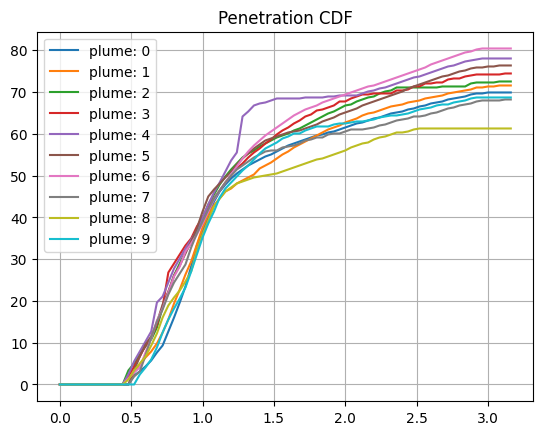

In [111]:
for idx, pen in enumerate(penetration_cdf):
    plt.plot(time_ms, px_per_mm*penetration_cdf[idx], label=f"plume: {idx}")

plt.title("Penetration CDF")
plt.legend()
plt.grid()


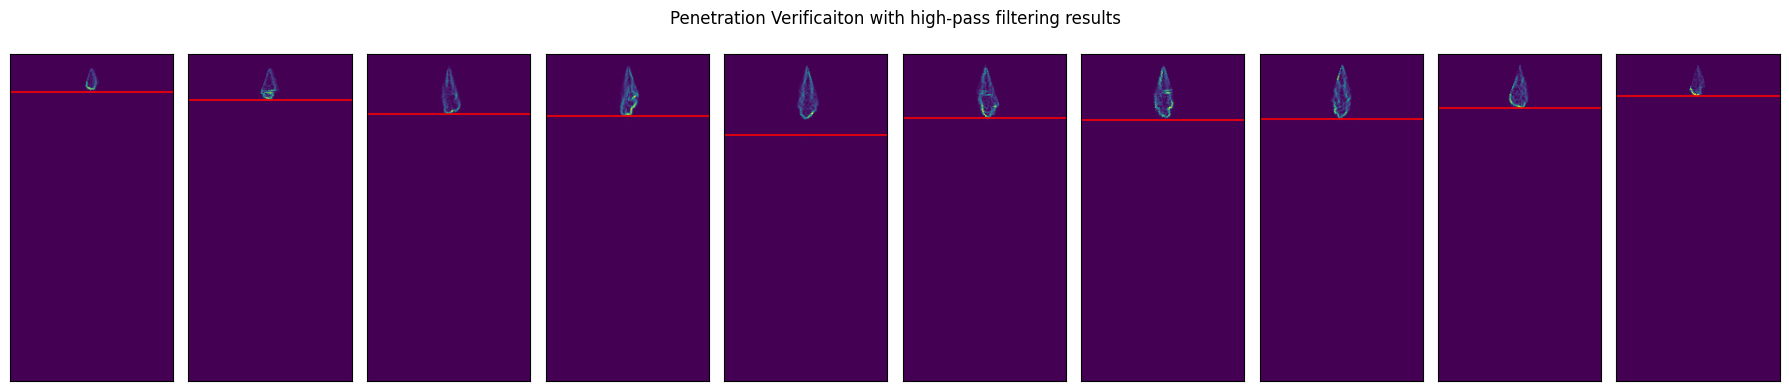

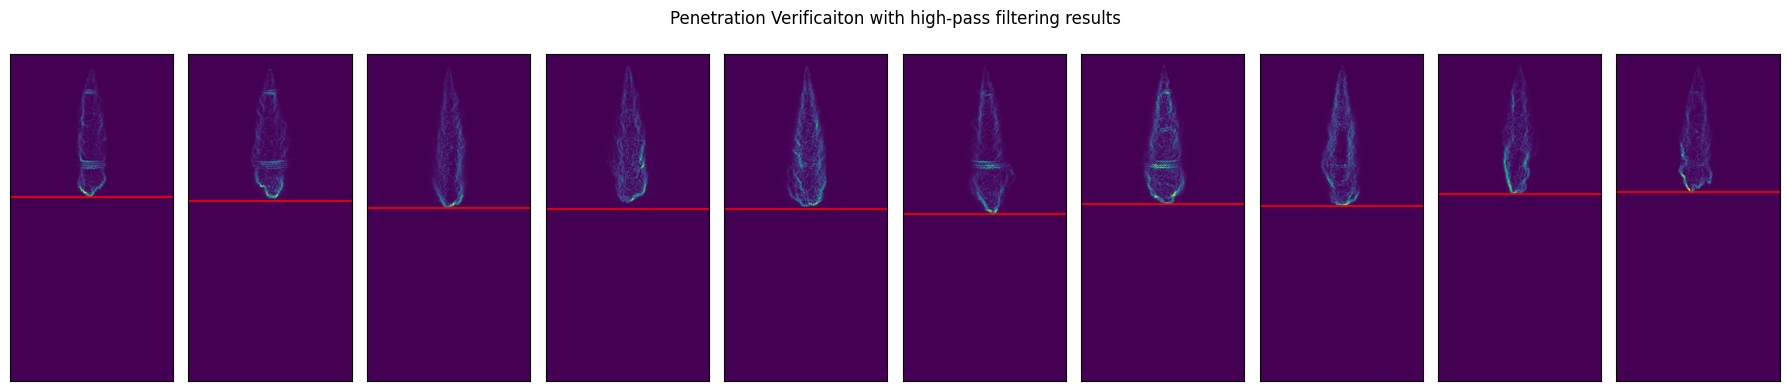

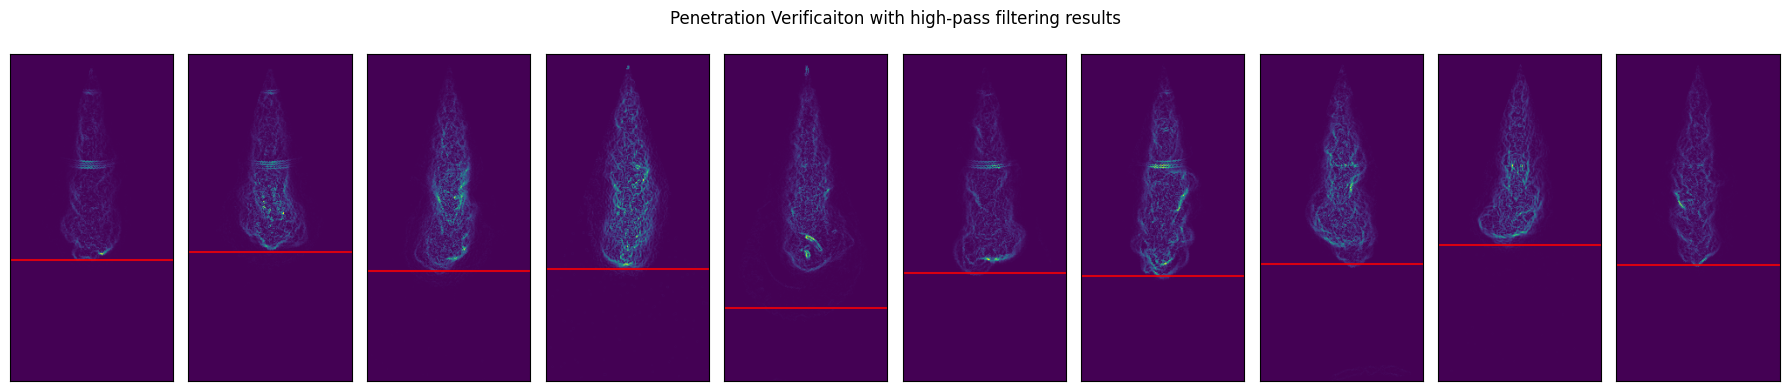

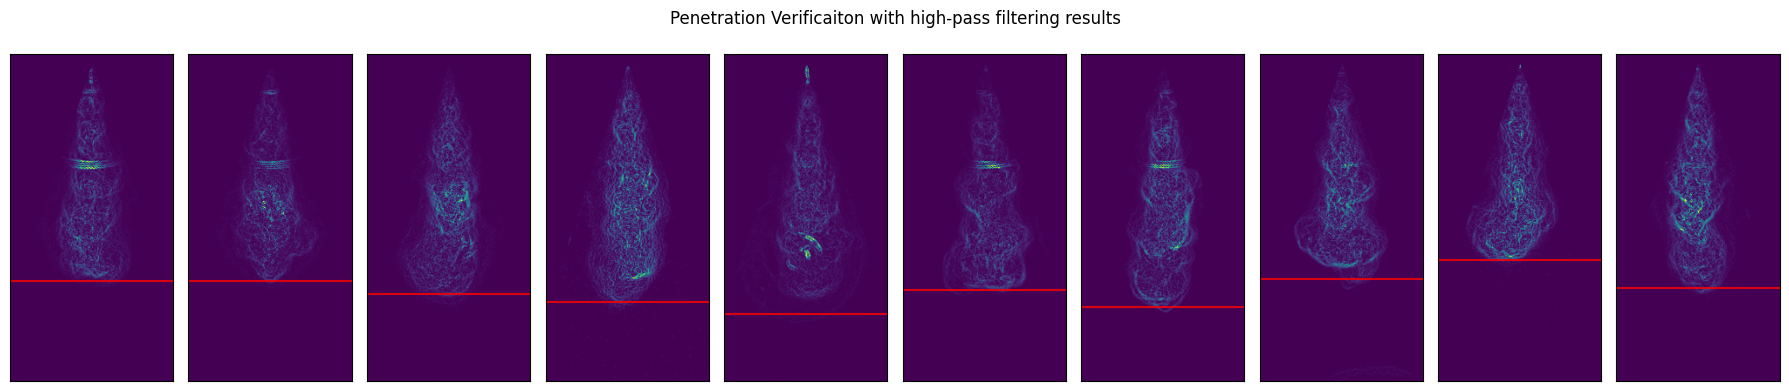

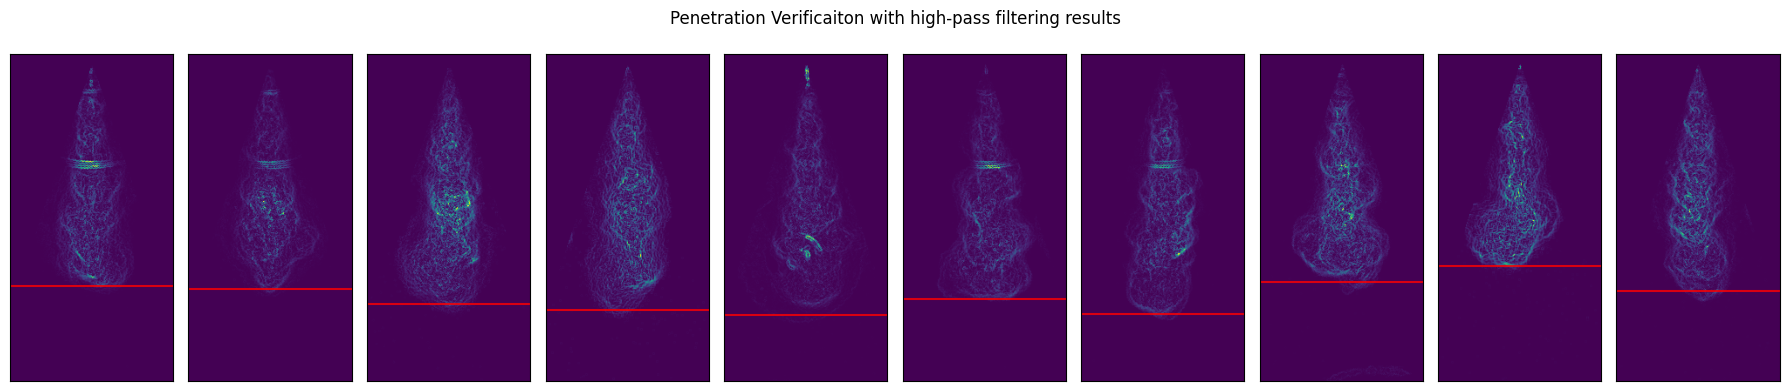

In [112]:
frame_num = [17, 25, 35, 45, 49]

for f in frame_num:

    fig, ax = plt.subplots(1, number_of_plumes, figsize=(18, 4))

    for n in range(number_of_plumes):
        ax[n].imshow(_as_numpy(xp.swapaxes(hp_segments, 2, 3)[n, f, :, :]))
        ax[n].axhline(_as_numpy(penetration_cdf[n, f] + ir_), color="r", alpha= 0.8)

    for axis in ax.ravel():
        axis.set_xticks([])
        axis.set_yticks([])

    fig.suptitle("Penetration Verificaiton with high-pass filtering results")
    plt.tight_layout()
    plt.show()

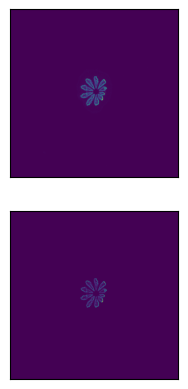

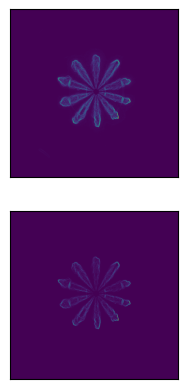

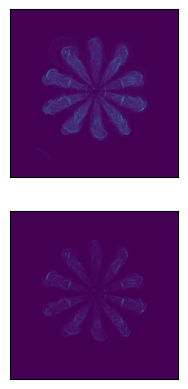

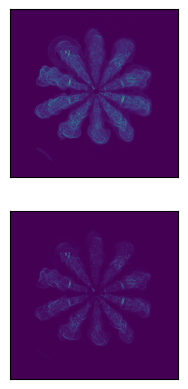

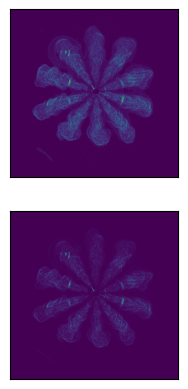

In [113]:
# plume_num = 4

for f in frame_num:

    fig, ax = plt.subplots(2, 1)
    ax[0].imshow(10*hp[f].get())
    ax[1].imshow(10*hp[f].get()**1.5)
    
    for axis in ax.ravel():
        axis.set_xticks([])
        axis.set_yticks([])
    plt.show()
